# Landmark detection using Dlib

## Imports

In [11]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Paths

In [13]:
LANDMARK_PREDICTOR_PATH = "../face_detection_model/shape_predictor_68_face_landmarks.dat"
FACE_PATH = "../dataset/face.jpg"
FER_PATH = "../dataset/fer-2013-images.npy"
OUTPUT_PATH = "../outputs/fer-2013-dlib-landmarks.npz"

## Pipeline

In [14]:
def get_grayscale(image):
  # Channel is 2 or more
  if image.shape[-1] > 1:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  else:
    gray = image.astype(np.uint8)
  return gray

In [15]:
def get_detected_faces(gray_image):
  # input is a grayscale image
  # this function return a list of detected faces
  # using dlib face detector
  detector = dlib.get_frontal_face_detector()
  detected_faces = detector(gray_image, 1)
  return detected_faces

In [16]:
def get_landmarks(gray_image, gray_face):
  # input is a grayscale face
  # using dlib shape detector with face landmarks input
  predictor = dlib.shape_predictor(LANDMARK_PREDICTOR_PATH)
  landmarks = predictor(gray_image, gray_face)
  return landmarks

In [17]:
def generate_part(part_arr_idx, landmarks):
  part = []
  for n in part_arr_idx:
    x = landmarks.part(n - 1).x
    y = landmarks.part(n - 1).y
    temp = np.array([x, y], np.float32)
    part.append(temp)
  part = np.array(part, dtype=np.int32)
  return part

In [18]:
def create_mask(image):
  mask = np.zeros_like(image)
  gray_image = get_grayscale(image)

  detected_faces = get_detected_faces(gray_image)

  ## no face detected
  if len(detected_faces) == 0:
    return mask, False

  landmarks = None
  for face in detected_faces:
    # there is just one face in each image of FER-2013
    # so this loop will be executed once
    landmarks = get_landmarks(gray_image, face)

  # Generate left eye part
  left_eye_idx = range(37, 43)
  left_eye = generate_part(left_eye_idx, landmarks)

  # Generate right eye part
  right_eye_idx = range(43, 49)
  right_eye = generate_part(right_eye_idx, landmarks)

  # Generate nose part
  nose_idx = [28, 32, 33, 34, 35, 36]
  nose = generate_part(nose_idx, landmarks)

  # Generate mouth part
  mouth_idx = range(49, 61)
  mouth = generate_part(mouth_idx, landmarks)

  contours = [left_eye, right_eye, nose, mouth]
  for cnt in contours:
    for x in range(mask.shape[0]):
      for y in range(mask.shape[1]):
        ret = cv2.pointPolygonTest(cnt, (y, x), False)
        if ret >= 0:
            mask[x, y, :] = image[x, y, :]
  
  return mask, True

In [19]:
def create_mask_wrapper(image):
  mask, flag = create_mask(image)
  return mask

## Test on a single image

(525, 525, 3)
(525, 525, 3)


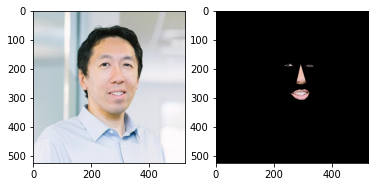

In [20]:
image = cv2.imread(FACE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
mask, flag = create_mask(image)
print(mask.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image)
ax2.imshow(mask)
plt.show()

## FER-2013

In [21]:
dataset_images = np.load(FER_PATH)
print(dataset_images.shape)

(35887, 48, 48, 1)


In [22]:
def get_smallset_landmarks(indexes):
  sample_size = indexes.shape[0]
  smallset_landmarks = np.empty(shape=(sample_size, 48, 48, 1))
  unmasked_count = 0
  i = 0
  for index in tqdm(indexes):
    image = dataset_images[index, :, :, :]
    mask, flag = create_mask(image)
    if not flag:
      unmasked_count += 1
    smallset_landmarks[i] = mask
    i += 1
  return smallset_landmarks, unmasked_count

In [23]:
indexes = np.arange(0, 20)
landmarks, unmasked = get_smallset_landmarks(indexes)
print('smallset unmasked count:', unmasked)
print('smallset landmarks shape:', landmarks.shape)

100%|██████████| 20/20 [00:17<00:00,  1.17it/s]

smallset unmasked count: 5
smallset landmarks shape: (20, 48, 48, 1)


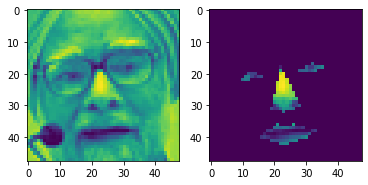

In [24]:
index = 0
base = 0
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(dataset_images[base + index].squeeze(axis=2))
ax2.imshow(landmarks[index].squeeze(axis=2))
plt.show()

In [25]:
# np.savez_compressed(OUTPUT_PATH, landmarks=landmarks)